In [4]:
pip install MyPreprocessors


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement MyPreprocessors (from versions: none)
ERROR: No matching distribution found for MyPreprocessors


In [2]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper


import joblib

In [3]:
dataTrain = pd.read_excel("DB4.xlsx")
dataTrain.head()

,id,year,dia_ocu,mes_ocu,dia_sem_ocu,hora_ocu,depto_ocu,Municipio,zona_ocu,sexo_fall_les,edad_fall_les,lesio_fall,tipo_vehi,MARCA,COLOR,MODELO,Causa_acc
0,NaN,2010,23,Septiembre,Jueves,7.0,Guatemala,NaN,5.0,Mujer,NaN,Lesionado,Automovil,NaN,NaN,NaN,Colision
1,NaN,2010,23,Septiembre,Jueves,7.0,Guatemala,NaN,5.0,Mujer,NaN,Lesionado,Automovil,NaN,NaN,NaN,Colision
2,NaN,2010,28,Marzo,Domingo,4.0,Guatemala,NaN,7.0,Mujer,NaN,Fallecido,Automovil,NaN,NaN,NaN,Colision
3,NaN,2010,7,Agosto,Sabado,8.0,Guatemala,NaN,7.0,Hombre,NaN,Lesionado,Automovil,NaN,NaN,NaN,Colision
4,NaN,2010,5,Julio,Lunes,20.0,Guatemala,NaN,7.0,Hombre,NaN,Lesionado,Automovil,NaN,NaN,NaN,Colision


In [4]:
# Calcular la proporción de valores nulos para cada columna
null_proportions = dataTrain.isnull().mean()

# Imprimir los resultados
for column, proportion in null_proportions.iteritems():
    print(f"% de NA para: '{column}' es: {proportion}")

    # Calcular la proporción de valores nulos para cada columna
null_proportions = dataTrain.isnull().mean()


% de NA para: 'id' es: 0.0002525167502777684
% de NA para: 'year' es: 0.0
% de NA para: 'dia_ocu' es: 0.0
% de NA para: 'mes_ocu' es: 0.0
% de NA para: 'dia_sem_ocu' es: 0.0
% de NA para: 'hora_ocu' es: 0.00027776842530554525
% de NA para: 'depto_ocu' es: 0.0
% de NA para: 'Municipio' es: 0.1196592707316252
% de NA para: 'zona_ocu' es: 0.7682485438200733
% de NA para: 'sexo_fall_les' es: 0.07842328541126561
% de NA para: 'edad_fall_les' es: 0.1321841015454025
% de NA para: 'lesio_fall' es: 4.208612504629474e-05
% de NA para: 'tipo_vehi' es: 0.04685869162654456
% de NA para: 'MARCA' es: 0.45554021750109425
% de NA para: 'COLOR' es: 0.3068667721625534
% de NA para: 'MODELO' es: 0.6874347665061783
% de NA para: 'Causa_acc' es: 0.0005555368506110905


In [5]:
#aquí encontramos las variables que tengan 5% o menos valores nulos, a estas variables se les puede hacer imputación.
cols_con_na = [col for col in dataTrain.columns if (dataTrain[col].isnull().mean() < 0.05)]
cols_con_na

['id',
 'year',
 'dia_ocu',
 'mes_ocu',
 'dia_sem_ocu',
 'hora_ocu',
 'depto_ocu',
 'lesio_fall',
 'tipo_vehi',
 'Causa_acc']

In [6]:
nuevo_df = dataTrain.loc[:, cols_con_na]
print(nuevo_df)

              id  year  dia_ocu     mes_ocu dia_sem_ocu  hora_ocu  \
0            NaN  2010       23  Septiembre      Jueves       7.0   
1            NaN  2010       23  Septiembre      Jueves       7.0   
2            NaN  2010       28       Marzo     Domingo       4.0   
3            NaN  2010        7      Agosto      Sabado       8.0   
4            NaN  2010        5       Julio       Lunes      20.0   
...          ...   ...      ...         ...         ...       ...   
118799  118770.0  2022       31   Diciembre      Sabado      22.0   
118800  118771.0  2022       31   Diciembre      Sabado      23.0   
118801  118772.0  2022       31   Diciembre      Sabado      18.0   
118802  118773.0  2022       31   Diciembre      Sabado      21.0   
118803  118774.0  2022       31   Diciembre      Sabado      22.0   

            depto_ocu lesio_fall    tipo_vehi  Causa_acc  
0           Guatemala  Lesionado    Automovil   Colision  
1           Guatemala  Lesionado    Automovil   Colis

In [7]:
data_numericas = nuevo_df.select_dtypes(include=['float', 'int'])
data_numericas

,id,year,dia_ocu,hora_ocu
0,NaN,2010,23,7.0
1,NaN,2010,23,7.0
2,NaN,2010,28,4.0
3,NaN,2010,7,8.0
4,NaN,2010,5,20.0
...,...,...,...,...
118799,118770.0,2022,31,22.0
118800,118771.0,2022,31,23.0
118801,118772.0,2022,31,18.0
118802,118773.0,2022,31,21.0


In [8]:
df = nuevo_df

In [10]:
def getDateColTypes(df):
    categoricas = []
    continuas = []
    discretas = []

    for colName in df.columns:
        if df[colName].dtype == "O":
            categoricas.append(colName)
        else:
            if((df[colName].dtype == "int64" or df[colName].dtypes == 'float64')):
                if (len(df[colName]) <=30):
                    discretas.append(colName)
                else:
                    continuas.append(colName)

    return discretas,continuas, categoricas


In [11]:
discretas,continuas, categoricas = getDateColTypes(df)

In [12]:
categoricas

['mes_ocu', 'dia_sem_ocu', 'depto_ocu', 'lesio_fall', 'tipo_vehi', 'Causa_acc']

In [13]:
discretas

[]

## Variables Categóricas

In [14]:
categoricas_df = dataTrain.loc[:, categoricas]
print(categoricas_df)

           mes_ocu dia_sem_ocu      depto_ocu lesio_fall    tipo_vehi  \
0       Septiembre      Jueves      Guatemala  Lesionado    Automovil   
1       Septiembre      Jueves      Guatemala  Lesionado    Automovil   
2            Marzo     Domingo      Guatemala  Fallecido    Automovil   
3           Agosto      Sabado      Guatemala  Lesionado    Automovil   
4            Julio       Lunes      Guatemala  Lesionado    Automovil   
...            ...         ...            ...        ...          ...   
118799   Diciembre      Sabado      Guatemala  Lesionado    Automovil   
118800   Diciembre      Sabado      Guatemala  Lesionado     Microbús   
118801   Diciembre      Sabado     Santa Rosa  Fallecido      Pick up   
118802   Diciembre      Sabado  Suchitepequez  Lesionado  Motocicleta   
118803   Diciembre      Sabado   Sacatepequez  Lesionado  Motocicleta   

        Causa_acc  
0        Colision  
1        Colision  
2        Colision  
3        Colision  
4        Colision  
...

## Variables Continuas

In [15]:
continuas_df = dataTrain.loc[:, continuas]
print(continuas_df)

              id  year  dia_ocu  hora_ocu
0            NaN  2010       23       7.0
1            NaN  2010       23       7.0
2            NaN  2010       28       4.0
3            NaN  2010        7       8.0
4            NaN  2010        5      20.0
...          ...   ...      ...       ...
118799  118770.0  2022       31      22.0
118800  118771.0  2022       31      23.0
118801  118772.0  2022       31      18.0
118802  118773.0  2022       31      21.0
118803  118774.0  2022       31      22.0

[118804 rows x 4 columns]


### Imputación continuas

In [16]:
def imputar_media(datos, columna):
    # Imputar valores faltantes con la media de la columna
    media = datos[columna].mean()
    datos_imputados = datos.copy()
    datos_imputados[columna].fillna(media, inplace=True)
    return datos_imputados

for columna in continuas:
    # Imputar valores faltantes con la media de la columna
    datos_imputados_media = imputar_media(df, columna)
    print(f"Datos imputados con media en columna {columna}:")
    print(datos_imputados_media.head())

Datos imputados con media en columna id:
        id  year  dia_ocu     mes_ocu dia_sem_ocu  hora_ocu  depto_ocu  \
0  59387.5  2010       23  Septiembre      Jueves       7.0  Guatemala   
1  59387.5  2010       23  Septiembre      Jueves       7.0  Guatemala   
2  59387.5  2010       28       Marzo     Domingo       4.0  Guatemala   
3  59387.5  2010        7      Agosto      Sabado       8.0  Guatemala   
4  59387.5  2010        5       Julio       Lunes      20.0  Guatemala   

  lesio_fall  tipo_vehi Causa_acc  
0  Lesionado  Automovil  Colision  
1  Lesionado  Automovil  Colision  
2  Fallecido  Automovil  Colision  
3  Lesionado  Automovil  Colision  
4  Lesionado  Automovil  Colision  
Datos imputados con media en columna year:
   id  year  dia_ocu     mes_ocu dia_sem_ocu  hora_ocu  depto_ocu lesio_fall  \
0 NaN  2010       23  Septiembre      Jueves       7.0  Guatemala  Lesionado   
1 NaN  2010       23  Septiembre      Jueves       7.0  Guatemala  Lesionado   
2 NaN  2010    

### Imputación Categóricas

In [17]:
def imputar_categorico(datos):
    datos_imputados = categoricas_df.copy()
    for columna in categoricas_df.columns:
        moda = categoricas_df[columna].mode().iloc[0]  # Obtener la moda
        datos_imputados[columna].fillna(moda, inplace=True)
    return datos_imputados

df_imputado_cat = imputar_categorico(categoricas_df)

print("DataFrame categoricas imputado:")
print(df_imputado_cat.head())

DataFrame categoricas imputado:
      mes_ocu dia_sem_ocu  depto_ocu lesio_fall  tipo_vehi Causa_acc
0  Septiembre      Jueves  Guatemala  Lesionado  Automovil  Colision
1  Septiembre      Jueves  Guatemala  Lesionado  Automovil  Colision
2       Marzo     Domingo  Guatemala  Fallecido  Automovil  Colision
3      Agosto      Sabado  Guatemala  Lesionado  Automovil  Colision
4       Julio       Lunes  Guatemala  Lesionado  Automovil  Colision


### Codificacion categorica

In [18]:
def generar_one_hot_encoding(datos):
    df_encoded = pd.get_dummies(datos)
    return df_encoded

df_encoded = generar_one_hot_encoding(df_imputado_cat)

print("DataFrame con One Hot Encoding:")
print(df_encoded.head())

DataFrame con One Hot Encoding:
   mes_ocu_Abril  mes_ocu_Agosto  mes_ocu_Diciembre  mes_ocu_Enero  \
0              0               0                  0              0   
1              0               0                  0              0   
2              0               0                  0              0   
3              0               1                  0              0   
4              0               0                  0              0   

   mes_ocu_Febrero  mes_ocu_Julio  mes_ocu_Junio  mes_ocu_Marzo  mes_ocu_Mayo  \
0                0              0              0              0             0   
1                0              0              0              0             0   
2                0              0              0              1             0   
3                0              0              0              0             0   
4                0              1              0              0             0   

   mes_ocu_Noviembre  ...  tipo_vehi_Taxi  tipo_vehi_Tractor

### Outliers

In [19]:
dataset = df


def getColumnTypes(dataset):
    '''Descripcion: Esta funcion extrae el tipo de dominio de las columnas de un dataset.
    Entradas: Pandas Dataframe
    Salida> Tupla con arreglo que contiene nombres de las columnas.'''

    continuas = []
    discretas = []
    categoricas = []

    for col in dataset.columns:
        if((dataset[col].dtype == 'int64') or (dataset[col].dtype == 'float64')):
            if(len(dataset[col].unique())>30):
                continuas.append(col)
            else:
                discretas.append(col)
        else:
            categoricas.append(col)
    return continuas, discretas, categoricas

In [20]:
import scipy.stats as stats

In [21]:
def plotDistBoxQQ(dataset, col):
    '''
    Descripción: Muestra las gráficas de Distribución, Boxplot y QQ-Plot para detectar Outliers.
    Imput: Dataset -> pandas dataframe, col -> string con nombre de columna
    Output: Visualización de plots.
    '''
    plt.figure(figsize=(20,6))

    plt.subplot(1,3,1) #grafica de 3 columnas y 1 fila
    sns.distplot(dataset[col], bins=30)
    plt.title("Histograma y Densidad")

    plt.subplot(1,3,2)
    sns.boxplot(y=dataset[col])
    plt.title('Boxplot')

    plt.subplot(1,3,3)
    stats.probplot(dataset[col], dist="norm", plot=plt)
    plt.title('Q-Q plot')

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

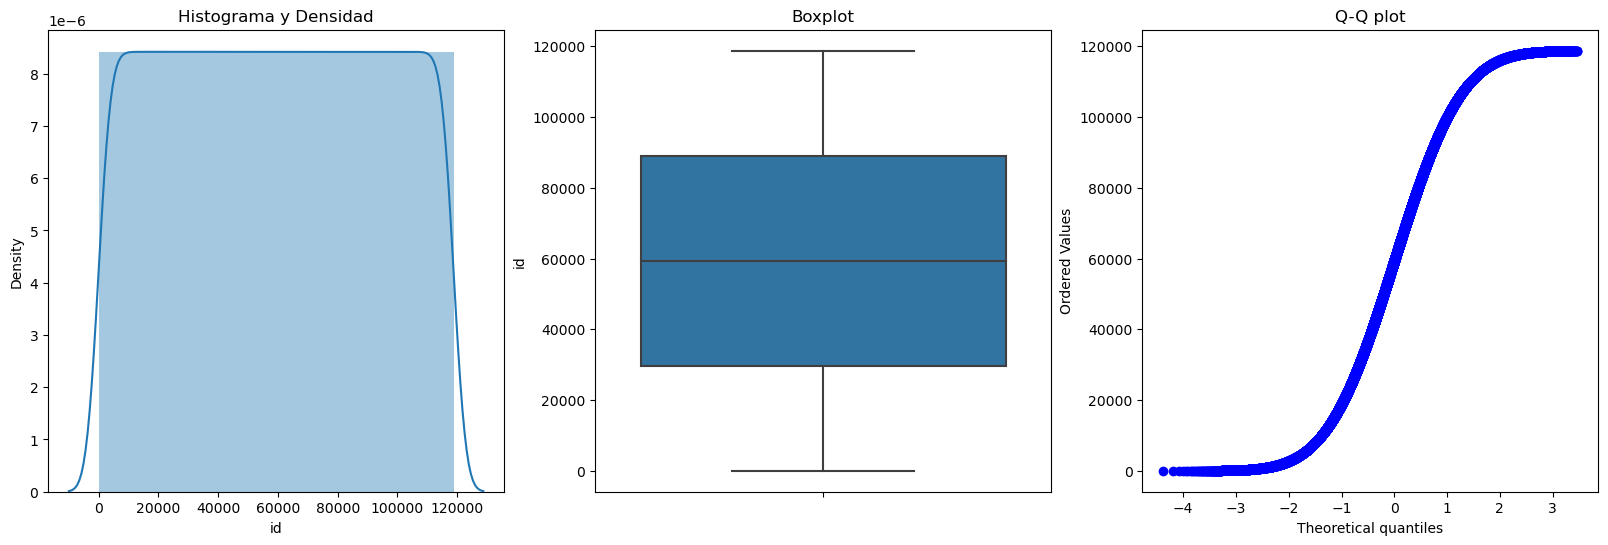

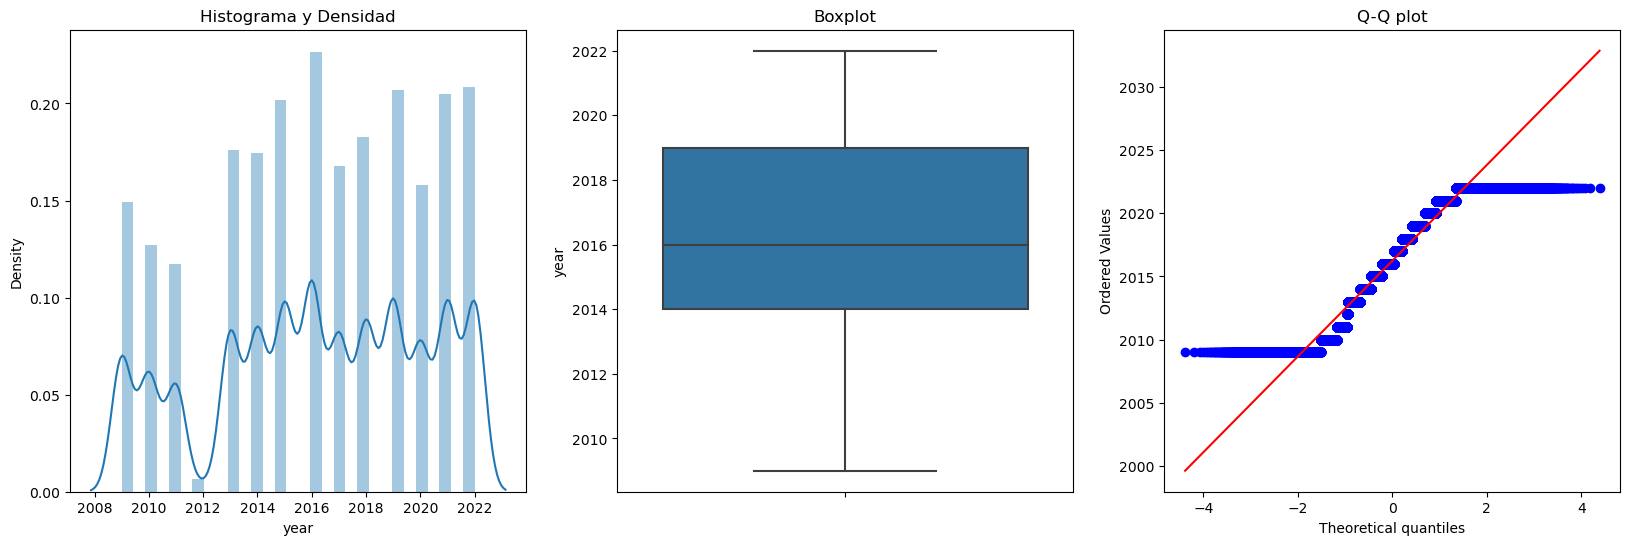

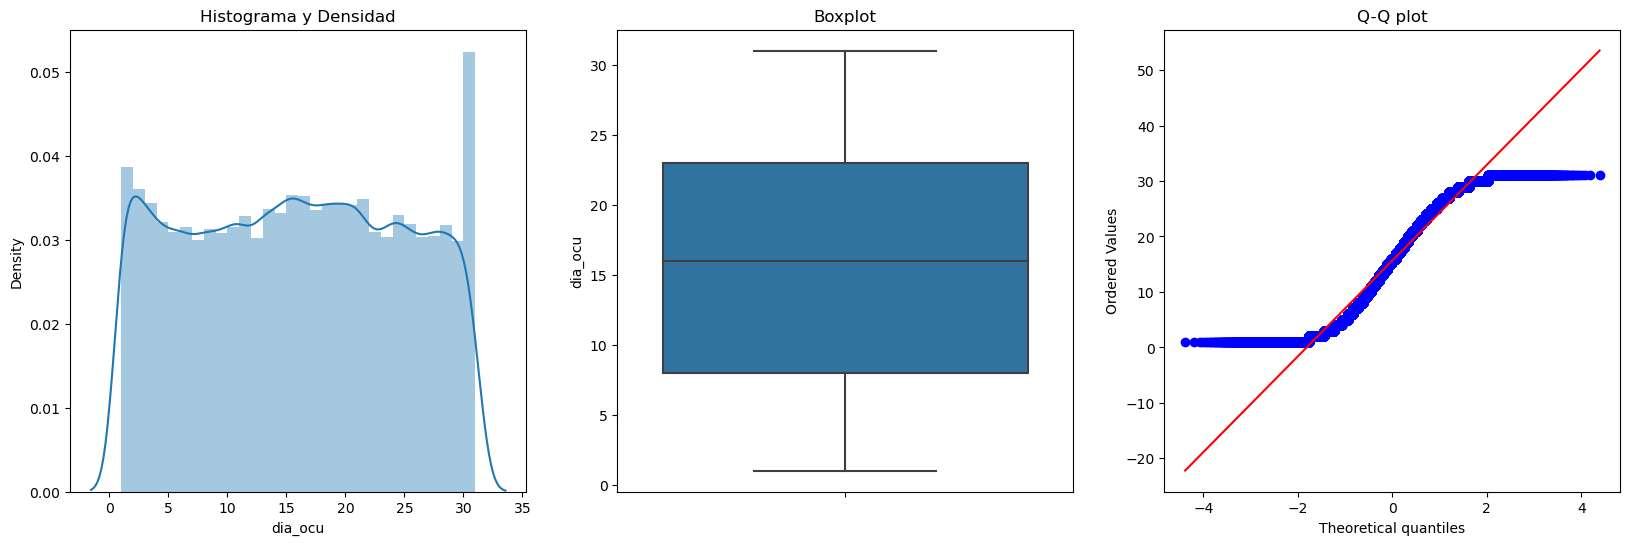

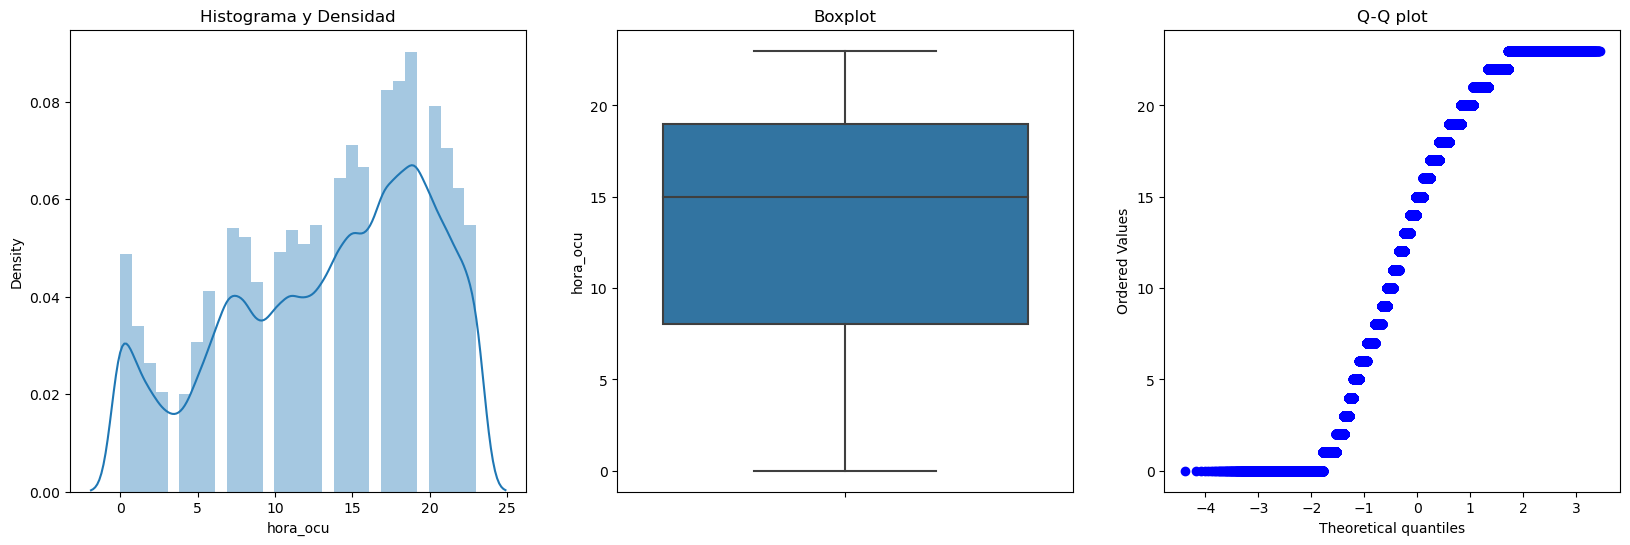

In [22]:
for col in continuas:
    
    plotDistBoxQQ(df,col)

### Estandarización de variables

In [23]:
from sklearn.preprocessing import StandardScaler

# Usar columnas numéricas
data_numericas = df.select_dtypes(include=['float', 'int'])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numericas)
data_scaled = pd.DataFrame(data_scaled, columns=data_numericas.columns)


data_scaled.describe()


,id,year,dia_ocu,hora_ocu
count,1.187740e+05,1.188040e+05,1.188040e+05,1.187710e+05
mean,1.207492e-17,-8.427311e-13,3.942280e-16,-6.032806e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.732036e+00,-1.855604e+00,-1.655125e+00,-2.077213e+00
25%,-8.660181e-01,-5.748496e-01,-8.638411e-01,-8.434416e-01
50%,0.000000e+00,-6.254787e-02,4.048393e-02,2.361086e-01
75%,8.660181e-01,7.059048e-01,8.317683e-01,8.529945e-01
max,1.732036e+00,1.474357e+00,1.736093e+00,1.469880e+00
